# Uplimit Practical A/B Testing Course: Project 1

## Background
Welcome to **TinyTravelers**! We are essentially Airbnb for families with young kids. You recently joined as a product data scientist on a team focused on growing the number of homes on the platform. They are currently focused on improving the onboarding flow and have some ideas for improvements, but they need your help!

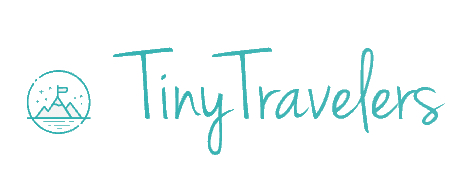

## Setup

Load data into Google Collab (remove this block if you are running it outside collab).

In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1kF06fIlFM6T6iXerDeyCHco75XvsyvKH/view?usp=sharing
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/14GI7--NWsWAoCUUm1l6hl24S87JPFJb9/view?usp=sharing
!gdown --no-cookies --fuzzy https://drive.google.com/file/d/1BK7YI9LRHhluMX7kHoLLQN29xjZ_L_Ju/view?usp=sharing

Downloading...
From: https://drive.google.com/uc?id=1kF06fIlFM6T6iXerDeyCHco75XvsyvKH
To: /content/dataset_autotitle.csv
100% 1.37M/1.37M [00:00<00:00, 90.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=14GI7--NWsWAoCUUm1l6hl24S87JPFJb9
To: /content/dataset_text_to_clicker.csv
100% 6.92M/6.92M [00:00<00:00, 107MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BK7YI9LRHhluMX7kHoLLQN29xjZ_L_Ju
To: /content/dataset_help_center.csv
100% 283k/283k [00:00<00:00, 108MB/s]


Import libraries

In [ ]:
# Lirbary basics
import numpy as np
import pandas as pd
import scipy.stats as stats # For pvalue

Helper function to get the 95% confidence interval. Inputs:
* Mean treatment - average conversion rate of the treatment group
* Mean control - average conversion rate of the control group
* N treatment - number of samples in the treatment group
* N control - number of samples in the control group
* ci = The width of the confidence interval. 0.95 by default

You can read more about p-values and confidence intervals in this week's [module](https://corise.com/course/practical-ab-testing/v2/enrollment/enrollment_clfveg8uy01o712ecb49scfbz/module/module_clgh2w6oh01i412b4haan88ut).

In [ ]:
def get_ci(mean_treatment, mean_control, n_treatment, n_control, ci = 0.95):
    sd = ((mean_treatment * (1 - mean_treatment)) / n_treatment + (mean_control * (1 - mean_control)) / n_control)**0.5
    lift = mean_treatment - mean_control
    val = stats.norm.isf((1 - ci) / 2)
    lwr_bnd = lift - val * sd
    upr_bnd = lift + val * sd
    return((lwr_bnd, upr_bnd))

Helper function to calcuate the results. It will compute and return the relative and absolute lift between variant and control, p-value, and lower and upper bound for the 95% confidence interval. A standard two-sided t-test with an assumption of equal variance is used to compute the p-value.

Inputs:
* DF = data frame with each row being a sample in the A/B test. It must have a column called "variant" that takes on the value "control" or "treatment
* Metric = the metric we want to evaluate. This must be 'new_active_listings','new_booked_listings', or 'new_cancelled_listings'). If it is not one of these values an "invalid metric" error will be thrown.

In [ ]:
def calculate_results(df,metric):
    # Check
    if metric not in ('new_active_listing','new_booked_listing','new_cancelled_listing'):
        raise Exception("Invalid metric")

    # Values and relative difference
    mean_control = df.loc[df['variant'] == "control",metric].mean()
    mean_treatment = df.loc[df['variant'] == "treatment",metric].mean()

    abs_diff = mean_treatment-mean_control
    rel_diff = (mean_treatment-mean_control)/mean_control

    # P-Value -- two-sided ttest, assumes normal distribution
    data_group1 = list(df.query('variant == "control"')[metric])
    data_group2 = list(df.query('variant == "treatment"')[metric])

    results = stats.ttest_ind(a=data_group1, b=data_group2, equal_var=True)
    pvaue = results.pvalue

    # 95% confidence intervals
    [ci_low, ci_high] = get_ci(mean_treatment,mean_control,len(data_group2),len(data_group1),.95)
    ci_low = ci_low/mean_control
    ci_high = ci_high/mean_control

    print("rel_diff, abs_diff, pvalue, ci_low, ci_high")
    return(rel_diff,abs_diff,results.pvalue,ci_low,ci_high)

## Task 1: Identify the target and guardrail metrics

As discussed in the [course material](https://uplimit.com/course/practical-ab-testing/v2/enrollment/enrollment_clikr4ejg000l119r4h45hs9w/module/module_cljt51a5s021613aw7mzqdbtx), when running an A/B test, the decision to launch is dependent on whether a target metric is stat-sig positive, assuming there is no detectable hit to the guardrail metrics. Picking the correct metrics is critical. You can revisit the content from lecture [here](https://uplimit.com/course/practical-ab-testing/v2/enrollment/enrollment_clikr4ejg000l119r4h45hs9w/module/module_cljt51a5s021613aw7mzqdbtx#corise_clhp2ofof000z3b6pt2t6ibr6). For convenience, the things to keep in mind when determining the target metric for an A/B test are below:

1. *Sensitivity*. Here the metrics are binary (0 or 1) so the higher the average rate, the better positioned you'll be to detect small changes.
2. *Timely*. Ideally the lag to measure the event tied to the metric is not too long.
3. *Business connection*. It is clear how optimizing the metric in an A/B test drives positive business value.

Since your team is focused on activation for hosts and are working in the onboarding flow, the new host user journey is the most relevant to your metric selection decision. The table below contains details about key steps in the journey, the percent that make it from one step to another, and how long it roughly takes for those who do make it. For now you can assume each host only has one home (aka listing).

| **User journey step**                | **Conversion rate from last step** | **Conversion rate from start** | **Median time since last step** |
|--------------------------------------|------------------------------------|--------------------------------|---------------------------------|
| Start onboarding flow                | N/A                                | N/A                            | N/A                             |
| Publish home/ finish onboarding flow | 40%                                | 40%                            | 2 hours                         |
| Home is booked by a guest            | 50%                                | 20%                            | 7 days                          |
| First guest stays at their home      | 90%                                | 18%                            | 14 days                         |
| Home receives the its first review   | 60%                                | 10.8%                          | 2 days                          |

Of the steps above, the most meaningful for the business is when the host receives their first review. This is important for both the demand (guests booking) and supply (hosts staying) aspects of the marketplace. When a listing is reviewed, it signals to a guest that this home is legit. You can imagine if you've never stayed at an Airbnb and the only option you see has no reviews, you might get scared and bring your business to a hotel instead. On the host side, receiving a review means you've already been paid, and is also positive (well, hopefully positive!) reinforcement that this hosting thing is worth your time. However, as we noted above, A/B testing against new reviewed listings might not be feasiable. What metric should we use?

### Task 1.a. Pros and cons of each metric

You are looking for a target metric the team can use for any change made in the onboarding flow, whether it's on the first page or the last. Empowered with the information shared in the table above, you've narrowed it down to 3 possible metrics:

1. New active listings - when the home (listing) is published
2. New booked listings - when the listing is first booked by a guest
3. New reviewed listings - when the listing receives its first review


Please list the pros and cons for each.

### New active listings
- PRO: Extremely timely (2 hours)
- PRO: Highest sensitivity (largest conversion rate from the start)
- PRO: This metric is closest to the product change we're making and what the team is meant to be optimizing.
- CON: Least valuable metric to the business in the onboarding flow; listing new homes does not equal revenue

### New booked listings
- PRO: Reasonably timely (7 days + 2 hours)
- PRO/CON: Mediocre sensitivity
- PRO: Valuable to the business; Even though this metric doesn't generate revenue directly, there is a high conversion rate from this step to the guest staying at the home which is a revenue generating action.

### New reviewed listings
- CON: Long lag time (23 days + 2 hours)
- CON: Worst sensitivity:
- CON: far away from the product change (improving the home listing onboarding) so lots of potential for confounding and affects from other a/b tests
- PRO: Most valuable to the business - guranteed revenue and improves the marketplace as more users will be likely to book this home in the future.

######**Hint**: Click to unhide

Remember, we need to balance practical considerations (how long will it take to get enough measurements?) with business considerations (if we optimize for the metric, will that get us closer to our actual goals?)"

### Task 1.b. Write which metric we should use and why

I would pick **New booked listings** since I believe it balances the sensitivity, timeliness, and business-connection triad most effectively.

However, if there are other teams in the org already working on optimizing this metric in other projects, I believe **New active listings** could also be a since it is the most directly connected to our team's goals and is extremely timely

### Task 1.c. List possible guardrail metrics

**New active listings**
- *New booked listings:* if it's super easy for hosts to make listings, maybe they reduce in quality as well as introduce noise in the marketplace for users
- *New reviewed listings:* if it's super easy for hosts to make listings, maybe they reduce in quality as well as introduce noise in the marketplace for users
- *Cancelled booked listings:* if it's super easy for hosts to make listings, then maybe they come too soon for the host, they panic and cancel

If we choose **New booked listings** as our target metric then optimizing this to infinity could negatively affect:
- New booking to stay conversion: when the listing receives it's first stay from a guest
- New booking to review conversion: when the listing receives it's first review

Assuming our team's work is successful in reducing the friction for potential guests to make a booking, then the likelihood of those guests converting to  staying and reviewing is likely to decrease because of this. This behaviour could be fine if the have enough New Bookings to increase revenue, however we must be conscious of these metrics to ensure these booking convert to revenue generating actions.

As discussed in the [metrics module](https://corise.com/course/practical-ab-testing/v2/enrollment/enrollment_clfveg8uy01o712ecb49scfbz/module/module_clgh2rpql01mj12e52bkmakp4) this week, guardrail metrics are the measurements you want to track to ensure that the change is not having unintended consequences. Please list a few possible guardrail metrics - there are many right answers here.

## Task 2: Design and analyze a test! Onboarding flow - auto-generate title

_**Warning**: This section gives away the answer to task 2, so please finish that first!_

After a discussion with PaM, we decided to use new booked listings (NBL) for the target metric and cancellations as our guardrail. We are also monitoring new active listings (NAL) to understand the impact on the funnel, but the impact on the metric won't matter for the decision to launch or not.

The team is now ready to start measuring the impact of their ideas!

One page of the onboarding (publish) flow is to create the title for the listing. The title of a listing shows up in search when guests are looking for a place to stay, so it's important. But the team knows a lot of people get stuck here and abort the flow. So they came up with an idea to make it easier... enter ChatGPT! Instead of asking a host to come up with their own title, a default title will be auto-generated, leveraging the information already known about the home (e.g. location, amentities). The specific design change is below.

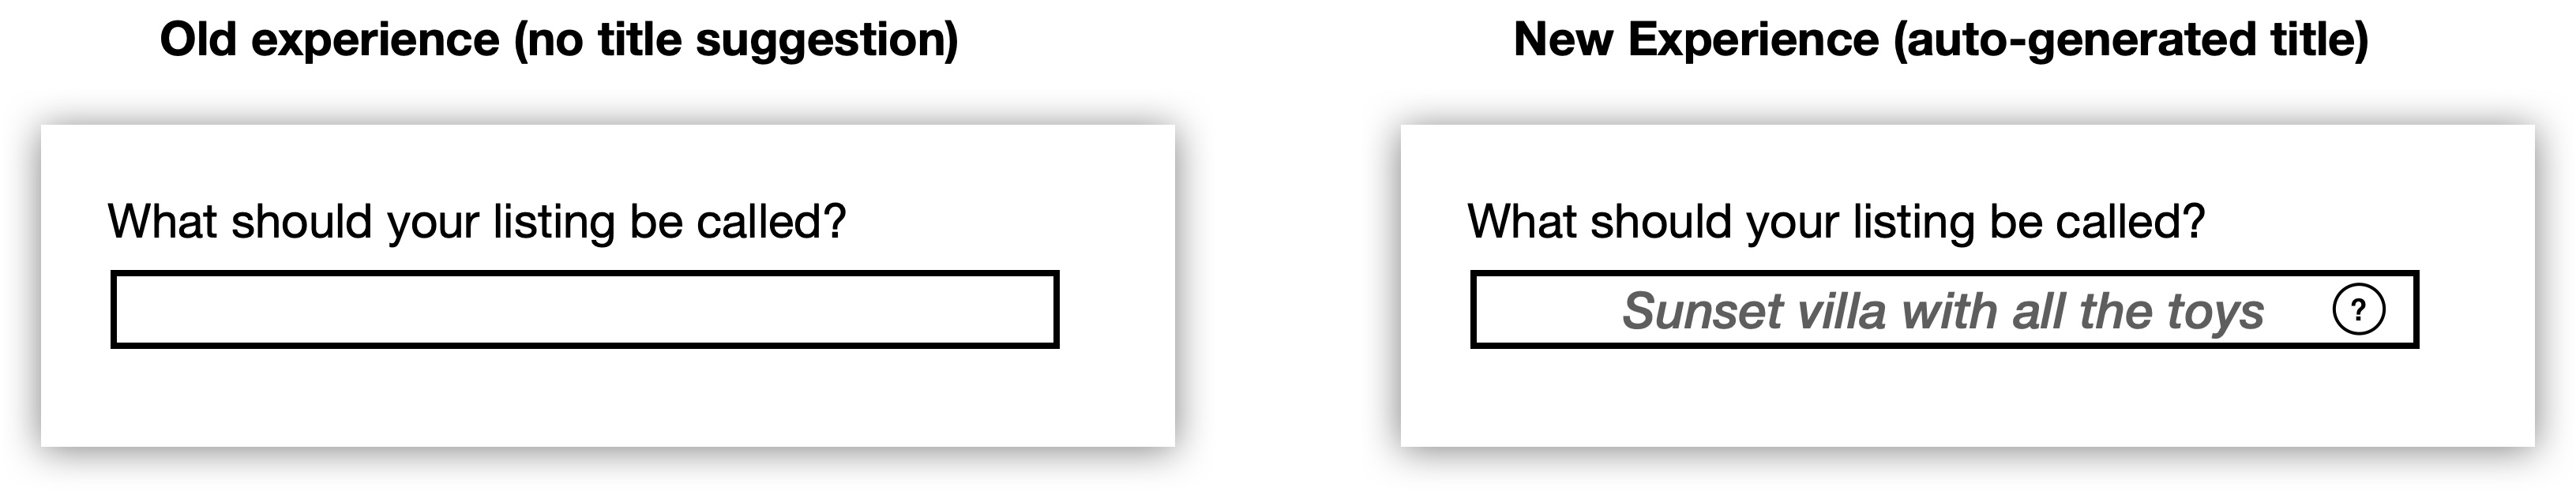

Due to the technical complexity of integrating with ChatGPT, we would need to see at least a _5% relative increase_ for this to be practically significant. Any smaller impact, even if positive, would not be worth it and we would choose not to launch.

### Task 2.a. Test design by answering the following...

#### Task 2.a.i. When should the test be triggered?

As close to the feature as possible such that the difference between the assigned users and exposed users is minimized

#### Task 2.a.ii. What is the hypothesis?

Note, as discussed the [test design module](https://uplimit.com/course/practical-ab-testing/v2/enrollment/enrollment_clikr4ejg000l119r4h45hs9w/module/test-design-basics#corise_clgpej5d700063b7125b1sdwy), a hypothesis should take on the form: "If we _\<product change\>_ it will increase _\<metric\>_, because _\<why you think that will happen\>_." You're welcome to write the null hypothesis as well but that's optional.



Hypothesis: By autogenerating the title, this will increase New Booked Listings (NBL) because it reduces the friction for potential hosts to make a listing (naming things is hard).

#### Task 2.a.iii. How long should the test run and how will the launch/ no launch decision be made?

You can assume _5k_ new people hit the triggering point each day. Remember PaM had determined that she only cares about 5% or more impact. Use Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html) to do the power analysis.

Assuming a baseline conversion rate of 20% for NBL and anminimum detectable effect (MDE) of a 5% relative increase, we require ~25,000 users per variant so 50,000 users total.

We therefore require 10 days to get enough people to trigger the assignment plus an extra 7 days to wait for the NBL metric to be measured.

We therefore predict this test to run for 17/18 days.

Source:
https://www.evanmiller.org/ab-testing/sample-size.html#!20;80;5;5;1

### Task 2.b. Test analysis

The results are in!!! Time to open the box and see what happened. Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided. The data has already been cleaned for you. There is information for three milestones:

* new_active_listing: 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing: 1 if a user had a new listing booked by a guest during the experiment. Otherwise 0.
* new_cancelled_listing: 1 if a user cancelled a new booking during the experiment. Otherwise 0.

_Basic_: What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) metrics? Do you recommend the team launch the change or not based on the results you observe?

_Bonus_: Dig further to understand if the change was driven entirely by improving conversion through the onboarding flow without changing appeal (aka any change detected for new booked listing was entirely driven by a lift in new active listings) or might the bookability/ appeal change as well?

In [ ]:
# If you are running locally: df_autotitle = pd.read_csv('./dataset_autotitle.csv') # Load the data
df_autotitle = pd.read_csv('/content/dataset_autotitle.csv') # Load data in Collab

In [ ]:
df_autotitle.head(10)

,id_user,variant,new_active_listing,new_booked_listing,new_cancelled_listing
0,48981,treatment,1,1,0
1,53434,control,1,0,0
2,43283,control,0,0,0
3,62347,treatment,1,1,0
4,10062,control,0,0,0
5,64223,control,0,0,0
6,69378,treatment,1,0,0
7,40832,treatment,0,0,0
8,30741,treatment,0,0,0
9,25799,treatment,1,0,0


TARGET
- statistically significant increase in our target metric ($\alpha < 0.05$)
- 95% CI does not cross 0
- good

In [ ]:
calculate_results(df_autotitle, 'new_booked_listing')

rel_diff, abs_diff, pvalue, ci_low, ci_high


(0.07765786534863514,
 0.011297328612152518,
 5.280265913312914e-05,
 0.04001708956912012,
 0.11529864112815014)

GUARDRAIL
- no change in guardrail metric that's stat-sig

In [ ]:
calculate_results(df_autotitle, 'new_cancelled_listing')

rel_diff, abs_diff, pvalue, ci_low, ci_high


(0.027864159246041294,
 0.00016684105860035724,
 0.7830975745453677,
 -0.17050818582211158,
 0.22623650431419418)

- extremely significant increase in new active listings indicating the onboarding change made by the team was successful and also caused an increase in New Booked Listings (NBL)

In [ ]:
calculate_results(df_autotitle, 'new_active_listing')

rel_diff, abs_diff, pvalue, ci_low, ci_high


(0.09772540077415333,
 0.039192859453873186,
 2.4414755658255822e-24,
 0.07891850397430467,
 0.11653229757400198)

I would conclude that auto-generating the title with ChatGPT produces a stat-sig increase in NAL and consequently NBL without significantly affecting NCL. We therefore should launch the feature.



### What happened?
_**Warning**: this will give away the answer to the previous task._

You brought your findings to PaM and the team and they were SO excited to see the impact of this change. It is clearly indicated that suggesting a title helped some stuck hosts-to-be get unstuck and the impact was well worth the cost of the technical integration. The change was launched to 100% with a pop of chatGPT champagne.

## Task 3: Design and analyze a test! Help chat.

The team wants to try having a support person available during the onboarding flow, with the hypothesis that it will give people the confidence they need to publish their home. The way they are implementing this is with a "painted door". Every host will have a "\(?\)" in the bottom left corner of every page of the flow. However, only 50% will be connected to a support person, with the other 50% being given a prompt around how no one is available. You can see the design and flow in the image below. It's not an ideal experience for the hosts, but it's temporary and we really want to isolate the impact of a help center.

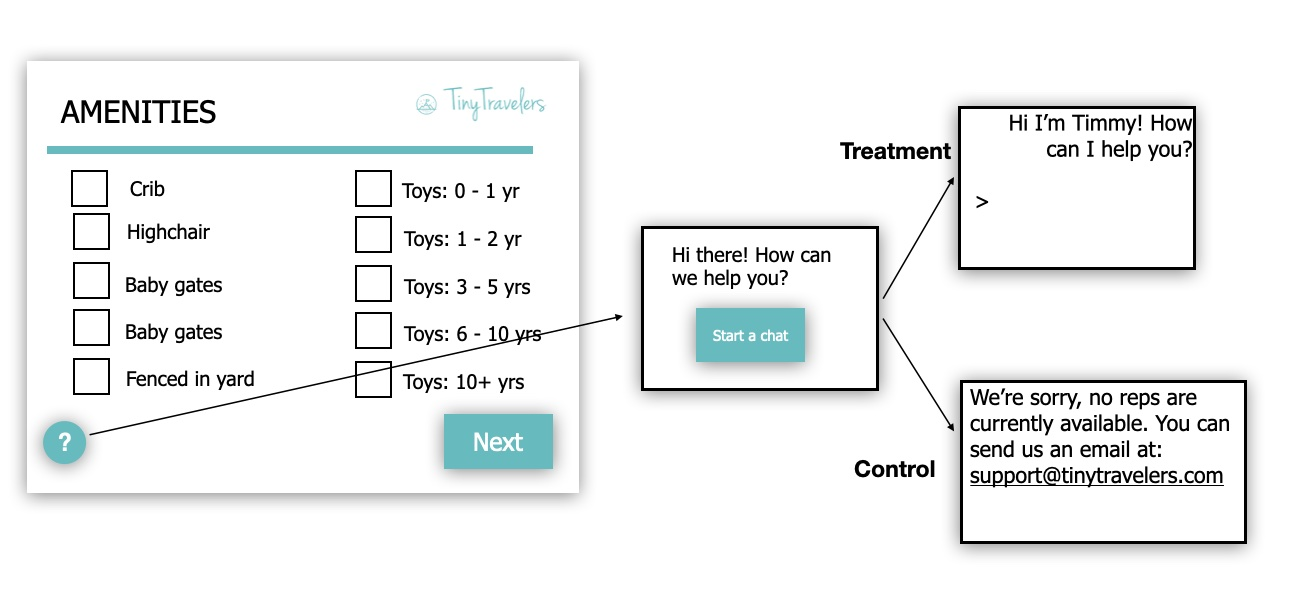

The test is triggered upon someone hitting the "\(?\)" button. The hypothesis is: If we connect a host looking for help with a human, NBL will increase because the host will have confidence (driving NAL), therefore also driving NBL.

If we go forward with this change, it'll be expensive. So PaM is looking for a big change here. She would only want to ship if the change is 8% or higher. At the same time, she does care about detecting meaningful changes and wants to make sure changes of 15% or greater on NBL are not missed. This is fortunate because we're in small(ish) data land.

You previously put the defunct painted door ("\(?\)" -> no one is available) in the onboarding flow in for a week, to check that it didn't majorly impact on NAL on it's own (it didn't) and to get an estimate of the volume. Turns out, you only have 250 people clicking that button each day. Their base conversion rates are lower than average too, with only 30% receiving an NAL and 10% receiving an NBL (start to publish = 30%, start to first booking = 10%).

### Task 3.a. Test design: How long should the test run and how will the launch/ no launch decision be made?

As mentioned above, only 250 people click the botton each day (that's the number of new users per day in your test). The conversion rate is 10%. Remember PaM had determined that she would not want to miss a 15% lift. Use Evan Miller's [sample size calculator](https://www.evanmiller.org/ab-testing/sample-size.html) to do the power analysis.

Assuming
- a baseline conversion rate of 30% for NAL
- An MDE of 15%
- $α = 5\%$
- $1 - \beta = 80\%$

We yield this test requires 1646 users per variant which is an approximate total of 3.3k

Assuming 250 users click the button per day and trigger the experiment, 3.3k / 250 = 14 days (rounding up).

Assuming
- a baseline conversion rate of 10% for NBL
- An MDE of 15%
- $α = 5\%$
- $1 - \beta = 80\%$

We yield this test requires 6401 users per variant which is an approximate total of 13k

Assuming 250 users click the button per day and trigger the experiment, 13k / 250 results in this test taking a total of 52 days

With these power analyses, I would advise the team to use NAL as the primary metric for this experiment for 2 primary reasons:
1. It is much faster
2. From previous experiments, we have seen that NAL tends to drive NBL so the business connection of both these metrics is of a similar calibre


##### Hint below

---



Recall in this week's material that we had a module section on working with small data ([here](https://uplimit.com/course/practical-ab-testing/v2/enrollment/enrollment_clikr4ejg000l119r4h45hs9w/module/module_cljt51aah021813awblyjh6kx#corise_clnqimd8w00013b8a9s1zszs9)). Some possibly relevant points are below:

* Maximize power by using metric with higher base rate.
* Increase risk tolerance by relaxing the p-value threshold (alpha) or power threshold (beta).
* Decide to ship with a neutral result.

| ------------------- |
_Write answer here_
| ------------------- |

### Task 3.b. Test analysis

After talking with PaM, you decided to run the test for 56 days at 50/50, and keep the p-value threshold at 0.05. Because employing humans to answer questions is expensive, you really want to be confident that the experience is positive. PaM wants to be as confident as possible that if we call something SS it's not due to noise, and that the quality bar of any incremental listings is maintained.

After a long waiting period, the results are finally in!!! Please analyze the test and summarize the learnings and recommendations for PaM and the team below with the A/B test data provided. The data has already been cleaned for you. There is information for three milestones:

* new_active_listing: 1 if a user published their listing during experiment. Otherwise 0.
* new_booked_listing: 1 if a user had a new listing booked by a guest during the experiment. Otherwise 0.
* new_cancelled_listing: 1 if a user cancelled a new booking during the experiment. Otherwise 0.

What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) metrics? Do you recommend the team launch the change or not based on the results you observe?

In [ ]:
# If you are running locally: df_autotitle = pd.read_csv('./dataset_autotitle.csv') # Load the data
df_help_center = pd.read_csv('/content/dataset_help_center.csv') # Load data in Collab

In [ ]:
calculate_results(df_help_center, 'new_booked_listing')

rel_diff, abs_diff, pvalue, ci_low, ci_high


(0.09855760780150317,
 0.009155167193116126,
 0.06779604376716991,
 -0.007233307081374994,
 0.2043485226843813)

In [ ]:
calculate_results(df_help_center, 'new_cancelled_listing')

rel_diff, abs_diff, pvalue, ci_low, ci_high


(0.32323436148746026,
 0.0013731281286638074,
 0.24609876488313343,
 -0.22357624385214397,
 0.8700449668270644)

With these results we observe
- a relative uplift of 10% (absolute uplift ~1%) in NBL at a $\alpha = 7\%$
- a relative uplift of 32% in Cancelled Listings (absolute uplift ~1%) at a $\alpha = 25\%$ level.

Prior to running the change, PaM stated she wanted to be really sure this change was positive and these results are far from confident. I would therefore suggest not launching the feature.

## Bonus 1: SUTVA

### Bonus 1.a. How might A/B testing in the onboarding flow violate SUTVA?

As a reminder, SUTVA implies that you can assume what treatment applies to the variant does not impact control.

I'm not sure how to answer this question except for the usual reasons listed in the course notes. I can't think of SUTVA violations specific to  onboarding flows.

## Bonus 2: Design and analyze another test! Onboarding flow - free text to clicker

One step in the onboarding flow is to change the guest details UI. The team believes that having a default and clicking to adjust the amounts will be less friction than typing.

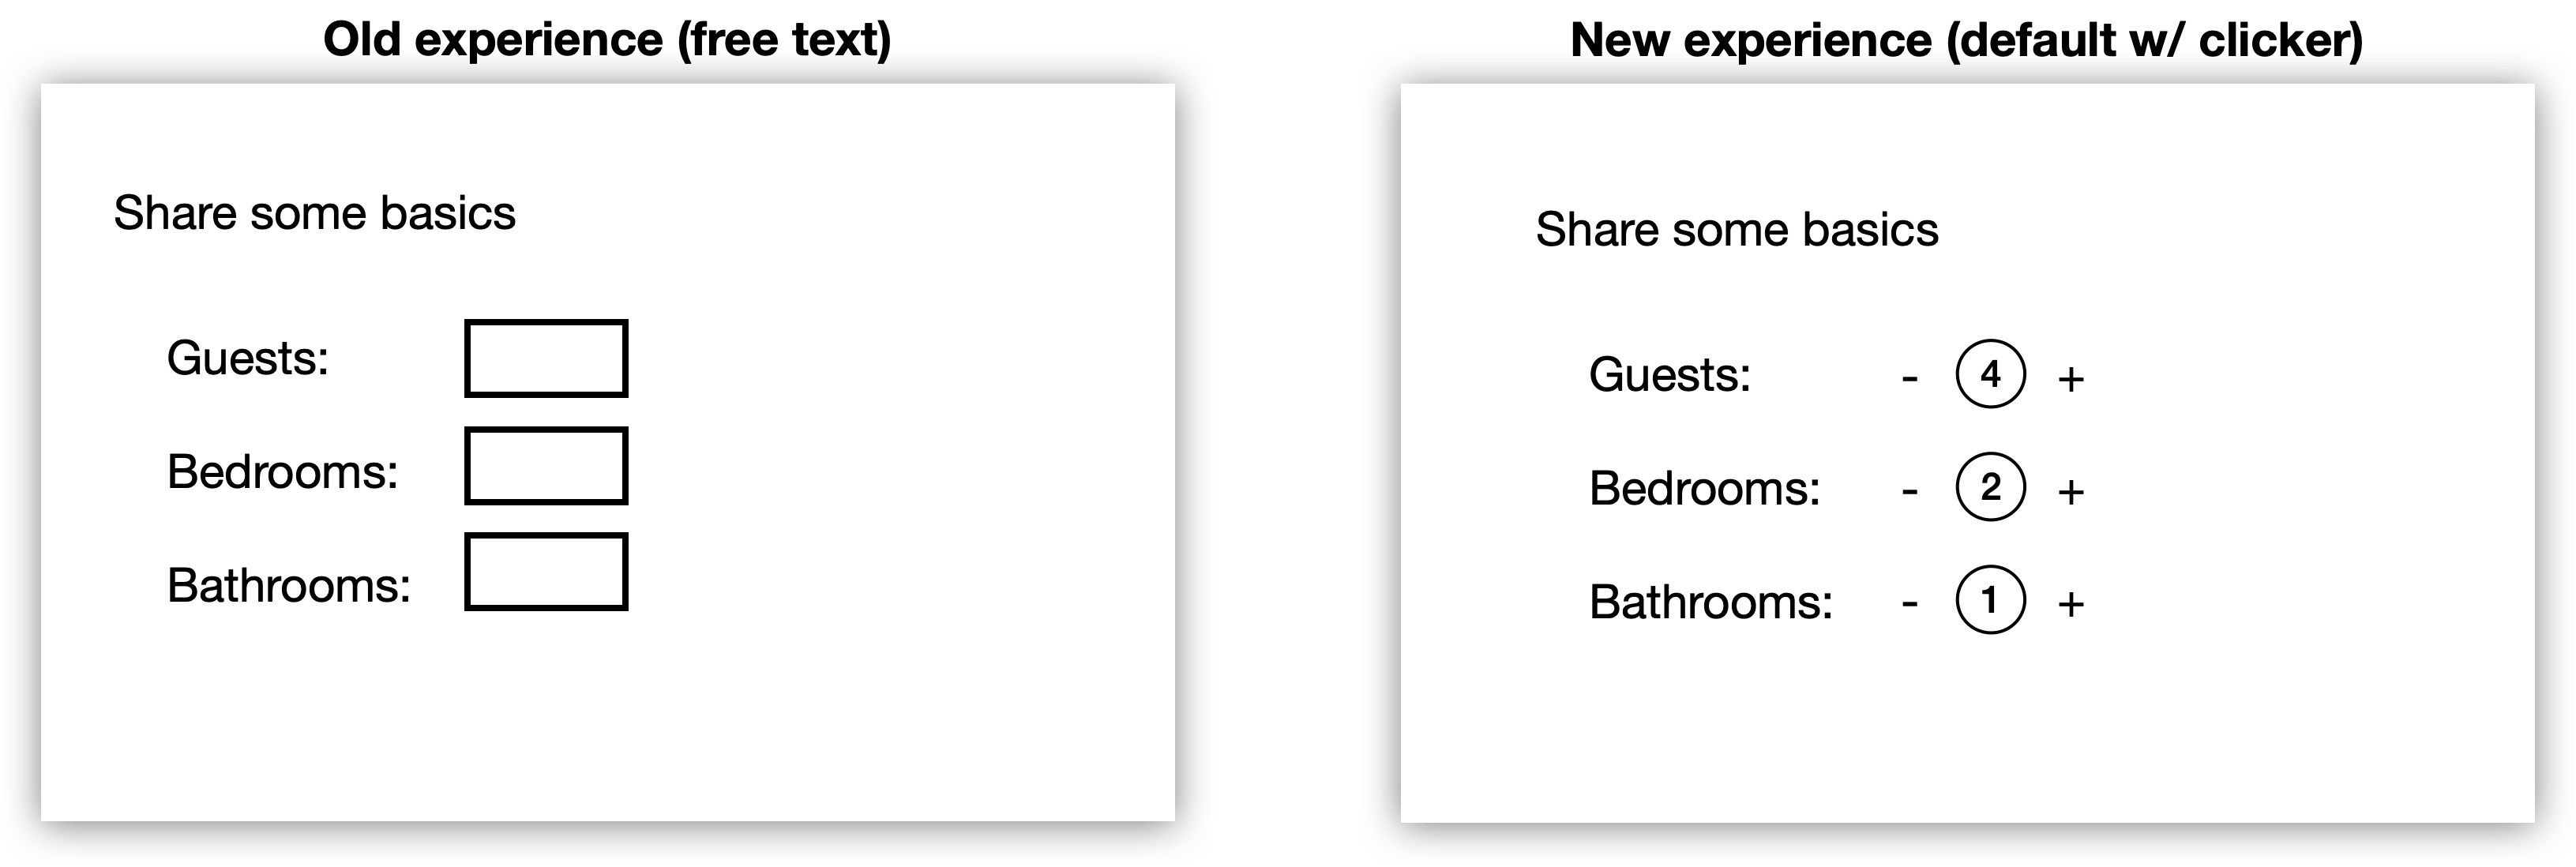

The hypothsis for this is change is: "If we change the free text field on the basics page to a clicker it will increase new booked listings because it will reduce the friction to publish a listing."

#### Bonus 2.a. How long should the test run and how will the launch/ no launch decision be made?

In this case PaM does care about detecting smaller changes and wants to be in position to capture a _2% relative increase_ if it exists. This change isn't blocking other planned work, so she is OK if we need to run it for up to 8 weeks. Of course, if we can detect a 2% change in fewer than 8 weeks that would be great. Fortunately there are more visitors to this page at the time this test is run, so you can assume _10K_ hit the triggering point each day.

| ------------------- |
_Write answer here_
| ------------------- |

### Bonus 2.b. Test analysis

Please analyze the test and summarize the learnings and recommendations for PaM and the team below. The datat has already been cleaned for you.

What happened at a high-level to the target (new booked listings) and guardrail (new cancelled listings) metrics, and do you recommend a launch or not based on that?

In [ ]:
# df_text_to_clicker = pd.read_csv('dataset_text_to_clicker.csv') # Load the file
df_text_to_clicker = pd.read_csv('/content/dataset_text_to_clicker.csv') # Load the file

# Code goes here

| ------------------- |
_Write findings and recommendation here_
| ------------------- |

### What happened?

_**Warning**: this will give away the answer to the previous task._

You brought the summary to PaM and the team. They were a bit disappointed their idea didn't pan out but understand not everything can work, and they were still happy from the auto-title change topped with champagne. So they rolled back the change and deleted the code supporting the clickers. Onward!